# Segmentación y Detección de Anomalías en Pacientes Crónicos
### K-Means no requerido; se emplean DBSCAN y HDBSCAN; Dimensionalidad con PCA, t-SNE/UMAP; Anomalías con Isolation Forest y One-Class SVM.



In [31]:
%pip install umap-learn hdbscan matplotlib seaborn scikit-learn pandas numpy


In [32]:
## Importación de librerías
import os, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.datasets import make_classification


# Opcionales
try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False

try:
    import hdbscan
    HAS_HDBSCAN = True
except Exception:
    HAS_HDBSCAN = False

warnings.filterwarnings("ignore")
RANDOM_STATE = 42

print("UMAP disponible:", HAS_UMAP, "| HDBSCAN disponible:", HAS_HDBSCAN)


UMAP disponible: True | HDBSCAN disponible: True


In [33]:
""" Carga el  dataset (desde url) y explorar
"""
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columnas = ['Embarazos', 'Glucosa', 'Presion', 'Pliegue', 'Insulina', 'IMC', 'DiabetesPedigree', 'Edad', 'Diabetes']
df = pd.read_csv(url, names=columnas) #librería pandas para leer el archivo
df.sample(8) # muestra 8 filas de forma aleatoria para una vista rapida



,Embarazos,Glucosa,Presion,Pliegue,Insulina,IMC,DiabetesPedigree,Edad,Diabetes
662,8,167,106,46,231,37.6,0.165,43,1
122,2,107,74,30,100,33.6,0.404,23,0
113,4,76,62,0,0,34.0,0.391,25,0
14,5,166,72,19,175,25.8,0.587,51,1
634,10,92,62,0,0,25.9,0.167,31,0
103,1,81,72,18,40,26.6,0.283,24,0
187,1,128,98,41,58,32.0,1.321,33,1
699,4,118,70,0,0,44.5,0.904,26,0


##Preprocesamiento
- Se separan variables explicativas (X) y objetivo (solo para referencia/validación, no supervisado).
- Escalado con `StandardScaler`.

In [34]:

np.random.seed(42)

features = [c for c in df.columns if c.lower() not in ("outcome","label","target","y")]
X = df[features].copy()
y = df[[c for c in df.columns if c.lower() in ("outcome","label","target","y")]].squeeze() if any(c.lower() in ("outcome","label","target","y") for c in df.columns) else None

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Dimensión X:", X.shape, "| Escalado listo.")


Dimensión X: (768, 9) | Escalado listo.


## Reducción de dimensionalidad (PCA, t-SNE, UMAP)
Se aplican **al menos dos** técnicas como exige la rúbrica.

In [35]:
# PCA a 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.sum()
print(f"PCA 2D - Varianza explicada acumulada: {explained:.3f}")

# t-SNE 2D (para visual)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, learning_rate='auto', init='pca')
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE 2D completado.")

# UMAP 2D si disponible
if HAS_UMAP:
    umap_model = umap.UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=15, min_dist=0.1, metric="euclidean")
    X_umap = umap_model.fit_transform(X_scaled)
    print("UMAP 2D completado.")
else:
    X_umap = None
    print("UMAP no disponible: instala 'umap-learn' si deseas incluirlo.")


PCA 2D - Varianza explicada acumulada: 0.459
t-SNE 2D completado.
UMAP 2D completado.


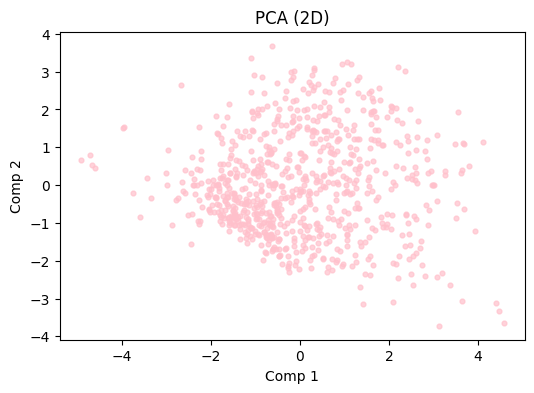

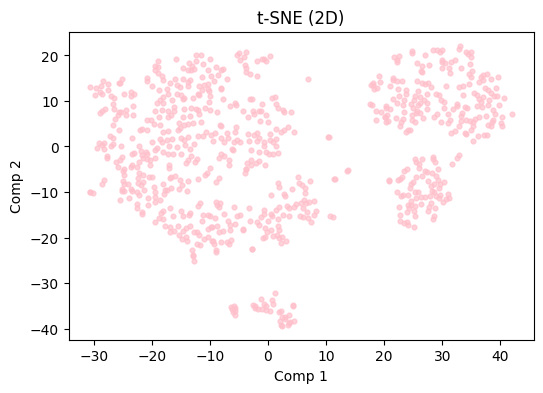

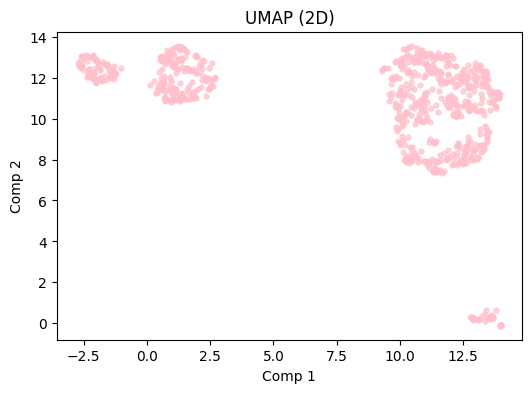

In [68]:
# Visualizaciones
def scatter_2d(Z, title, color=None):
    plt.figure(figsize=(6,4))
    # Usando un color morado específico y visible
    plt.scatter(Z[:,0], Z[:,1], s=12, alpha=0.7, color='pink')
    plt.title(title)
    plt.xlabel("Comp 1")
    plt.ylabel("Comp 2")
    plt.show()

scatter_2d(X_pca, "PCA (2D)")
scatter_2d(X_tsne, "t-SNE (2D)")
if X_umap is not None:
    scatter_2d(X_umap, "UMAP (2D)")

## Segmentación por densidad (DBSCAN & HDBSCAN)

In [37]:
def cluster_and_eval(Z, name, algo, **kwargs):
    model = algo(**kwargs)
    labels = model.fit_predict(Z)
    # Ajuste: HDBSCAN usa labels -1 para ruido; DBSCAN igual
    # Silueta solo se calcula si hay >= 2 clústeres válidos (excluyendo -1) y no todos son -1
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    sil, dbi = np.nan, np.nan
    valid_mask = labels != -1
    if n_clusters >= 2 and valid_mask.sum() > 1:
        sil = silhouette_score(Z[valid_mask], labels[valid_mask])
        dbi = davies_bouldin_score(Z[valid_mask], labels[valid_mask])
    return labels, n_clusters, sil, dbi

# Usamos el espacio PCA por estabilidad de métricas
labels_db, k_db, sil_db, dbi_db = cluster_and_eval(X_pca, "DBSCAN", DBSCAN, eps=0.8, min_samples=8)
print(f"DBSCAN -> clusters: {k_db} | Silueta: {sil_db:.3f} | Davies-Bouldin: {dbi_db:.3f}")

if HAS_HDBSCAN:
    labels_hdb, k_hdb, sil_hdb, dbi_hdb = cluster_and_eval(X_pca, "HDBSCAN", hdbscan.HDBSCAN, min_cluster_size=20, min_samples=10)
    print(f"HDBSCAN -> clusters: {k_hdb} | Silueta: {sil_hdb:.3f} | Davies-Bouldin: {dbi_hdb:.3f}")
else:
    labels_hdb = None
    print("HDBSCAN no disponible: instala 'hdbscan' para ejecutar esta parte.")


DBSCAN -> clusters: 1 | Silueta: nan | Davies-Bouldin: nan
HDBSCAN -> clusters: 2 | Silueta: 0.439 | Davies-Bouldin: 0.580


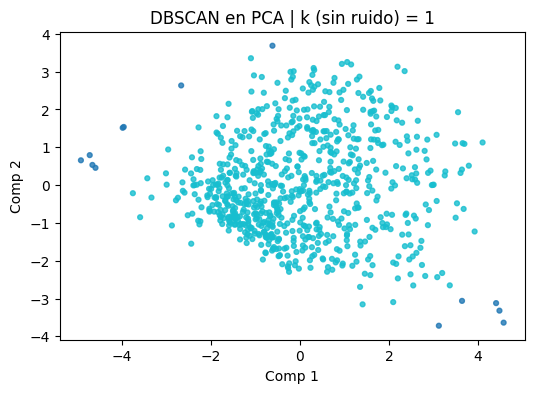

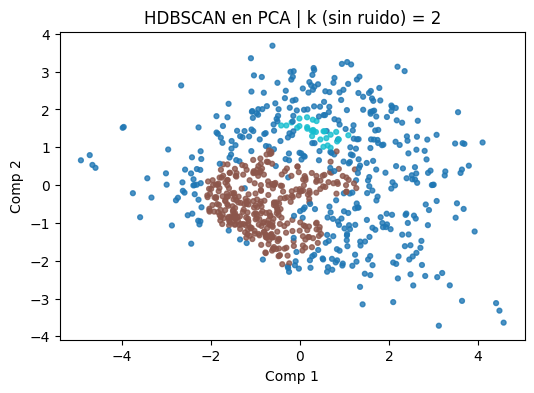

In [81]:
# Visualizaciones de clústeres
def plot_clusters(Z, labels, title):
    plt.figure(figsize=(6,4))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=12, alpha=0.8, cmap="tab10")
    plt.title(title + f" | k (sin ruido) = {len(set(labels)) - (1 if -1 in labels else 0)}")
    plt.xlabel("Comp 1")
    plt.ylabel("Comp 2")
    plt.show()

plot_clusters(X_pca, labels_db, "DBSCAN en PCA")
if labels_hdb is not None:
    plot_clusters(X_pca, labels_hdb, "HDBSCAN en PCA")

## Detección de anomalías (Isolation Forest & One-Class SVM)

In [39]:
iso = IsolationForest(random_state=RANDOM_STATE, contamination=0.05)
iso_scores = iso.fit_predict(X_scaled)  # -1 anómalo, 1 normal

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm_scores = ocsvm.fit_predict(X_scaled)  # -1 anómalo, 1 normal

anom_iso_idx = np.where(iso_scores == -1)[0]
anom_svm_idx = np.where(ocsvm_scores == -1)[0]
print(f"IsolationForest anómalos: {len(anom_iso_idx)} | One-Class SVM anómalos: {len(anom_svm_idx)}")

# Mostrar algunos ids
print("IDs anómalos (IF) ->", anom_iso_idx[:15])
print("IDs anómalos (OCSVM) ->", anom_svm_idx[:15])


IsolationForest anómalos: 39 | One-Class SVM anómalos: 48
IDs anómalos (IF) -> [  4   8  12  13  39  43  45  49  58 125 186 193 220 228 247]
IDs anómalos (OCSVM) -> [  4   7   8   9  13  57  58 125 129 154 159 177 182 186 211]


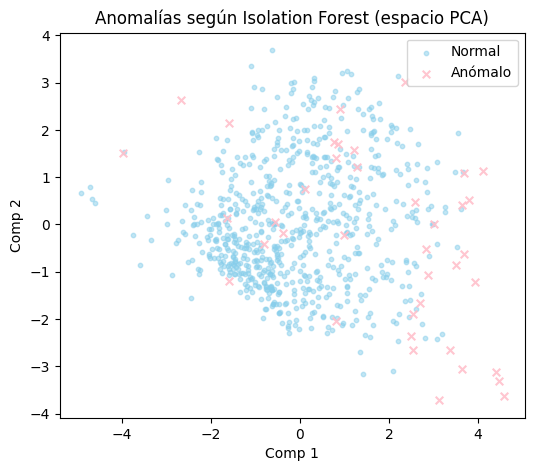

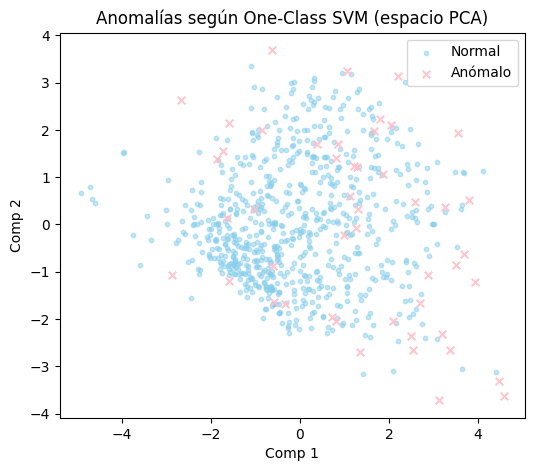

In [65]:
# Visualización de anomalías sobre PCA
def plot_anomalies(Z, anomalies_idx, title):
    plt.figure(figsize=(6,4))
    # Identificar índices de puntos normales
    normal_mask = np.ones(len(Z), dtype=bool)
    normal_mask[anomalies_idx] = False
    normal_idx = np.where(normal_mask)[0]

    # Usando colores púrpura y magenta
    plt.scatter(Z[normal_idx,0], Z[normal_idx,1], s=10, alpha=0.5, color='skyblue', label="Normal")
    if len(anomalies_idx):
        plt.scatter(Z[anomalies_idx,0], Z[anomalies_idx,1], s=30, alpha=0.9, marker='x', color='pink', label="Anómalo")
    plt.title(title)
    plt.legend()
    plt.xlabel("Comp 1")
    plt.ylabel("Comp 2")
    plt.show()

plot_anomalies(X_pca, anom_iso_idx, "Anomalías según Isolation Forest (espacio PCA)")
plot_anomalies(X_pca, anom_svm_idx, "Anomalías según One-Class SVM (espacio PCA)")

## Análisis cruzado: ¿coinciden anomalías con clústeres raros?

In [41]:
import collections

def anomalies_vs_clusters(labels, anomalies_idx, name):
    if labels is None:
        print(f"{name}: sin etiquetas de clúster (no disponible).")
        return None
    cluster_of_anom = labels[anomalies_idx]
    counter = collections.Counter(cluster_of_anom)
    print(f"{name} -> distribución de anomalías por clúster (incluye ruido -1):", dict(counter))
    return counter

print("==> Cruce con DBSCAN")
count_db_if = anomalies_vs_clusters(labels_db, anom_iso_idx, "IF vs DBSCAN")
count_db_oc = anomalies_vs_clusters(labels_db, anom_svm_idx, "OCSVM vs DBSCAN")

if labels_hdb is not None:
    print("\n==> Cruce con HDBSCAN")
    count_hdb_if = anomalies_vs_clusters(labels_hdb, anom_iso_idx, "IF vs HDBSCAN")
    count_hdb_oc = anomalies_vs_clusters(labels_hdb, anom_svm_idx, "OCSVM vs HDBSCAN")


==> Cruce con DBSCAN
IF vs DBSCAN -> distribución de anomalías por clúster (incluye ruido -1): {np.int64(0): 32, np.int64(-1): 7}
OCSVM vs DBSCAN -> distribución de anomalías por clúster (incluye ruido -1): {np.int64(0): 43, np.int64(-1): 5}

==> Cruce con HDBSCAN
IF vs HDBSCAN -> distribución de anomalías por clúster (incluye ruido -1): {np.int64(-1): 34, np.int64(0): 4, np.int64(1): 1}
OCSVM vs HDBSCAN -> distribución de anomalías por clúster (incluye ruido -1): {np.int64(-1): 40, np.int64(1): 2, np.int64(0): 6}


In [42]:
## Conclusiones y reflexión final


def resumen():
    lines = []
    lines.append("=== RESUMEN DE RESULTADOS ===")
    lines.append(f"- PCA 2D varianza acumulada: {pca.explained_variance_ratio_.sum():.3f}")
    lines.append(f"- DBSCAN: k={len(set(labels_db)) - (1 if -1 in labels_db else 0)} | Silueta={sil_db:.3f} | Davies-Bouldin={dbi_db:.3f}")
    if 'labels_hdb' in globals() and labels_hdb is not None:
        lines.append(f"- HDBSCAN: k={len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)} | Silueta={sil_hdb:.3f} | Davies-Bouldin={dbi_hdb:.3f}")
    lines.append(f"- Anomalías IF: {len(anom_iso_idx)} | Anomalías OCSVM: {len(anom_svm_idx)}")
    lines.append("")
    lines.append("=== INTERPRETACIÓN CLÍNICA (guía) ===")
    lines.append("* Segmentos pueden representar perfiles con distinta combinación de riesgo (glucosa, IMC, edad, etc.).")
    lines.append("* Los puntos de ruido (-1) y anomalías podrían indicar errores de captura o casos clínicos emergentes a priorizar.")
    lines.append("* Comparar IF vs OCSVM: coincidencias refuerzan la sospecha clínica; discrepancias motivan revisión manual.")
    lines.append("")
    lines.append("=== RECOMENDACIÓN ===")
    lines.append("* Usar HDBSCAN cuando esté disponible por su robustez a densidades variables y soft clustering (probabilidades).")
    lines.append("* Mantener PCA para estabilizar métricas; usar t-SNE/UMAP para comunicación visual.")
    print("\n".join(lines))

resumen()


=== RESUMEN DE RESULTADOS ===
- PCA 2D varianza acumulada: 0.459
- DBSCAN: k=1 | Silueta=nan | Davies-Bouldin=nan
- HDBSCAN: k=2 | Silueta=0.439 | Davies-Bouldin=0.580
- Anomalías IF: 39 | Anomalías OCSVM: 48

=== INTERPRETACIÓN CLÍNICA (guía) ===
* Segmentos pueden representar perfiles con distinta combinación de riesgo (glucosa, IMC, edad, etc.).
* Los puntos de ruido (-1) y anomalías podrían indicar errores de captura o casos clínicos emergentes a priorizar.
* Comparar IF vs OCSVM: coincidencias refuerzan la sospecha clínica; discrepancias motivan revisión manual.

=== RECOMENDACIÓN ===
* Usar HDBSCAN cuando esté disponible por su robustez a densidades variables y soft clustering (probabilidades).
* Mantener PCA para estabilizar métricas; usar t-SNE/UMAP para comunicación visual.


## README

*Objetivo*

Identificar segmentos de pacientes y casos atípicos que requieran revisión prioritaria, usando técnicas no supervisadas: reducción de dimensionalidad, DBSCAN/HDBSCAN y detección de anomalías (Isolation Forest, One-Class SVM).

#Metodología

*Reducción de dimensionalidad*:

        PCA (2D) para estabilizar métricas y explicar varianza.

        t-SNE (2D) para separar visualmente estructuras no lineales.

        UMAP (2D) opcional.

*Clustering por densidad*:

        DBSCAN (hiperparámetros clave: eps, min_samples).

        HDBSCAN (si está disponible; robusto a densidades variables).

*Métricas de calidad (excluyendo ruido -1)*:

    Silhouette (mientras más alto mejor) y Davies–Bouldin (mientras más bajo mejor).

*Anomalías*:

        Isolation Forest (contamination≈0.05).

        One-Class SVM (rbf, nu≈0.05).

*Análisis cruzado:*

    coincidencia de anomalías con ruido o clústeres muy pequeños.



**Análisis de resultados**

*Estructura del espacio (PCA / t-SNE / UMAP)*

    •	PCA 2D – Varianza explicada: 0,459. Es decir, en 2 componentes lineales capturas ~46% de la estructura: moderado. Suficiente para métricas, pero no para ver toda la forma de los datos.

    •	t-SNE y UMAP: las gráficas muestran islas claras; confirman que hay separación no lineal que PCA no alcanza a reflejar del todo. Traducción: visualmente hay grupos; linealmente, la cosa es más mezclada.

*Segmentación por densidad*

    •	DBSCAN → k=1 (sin ruido), Silueta: NaN, Davies–Bouldin: NaN. Con estos hiperparámetros (p.ej., eps=0.8, min_samples=8) no logró separar en ≥2 clústeres válidos. Señal de que:
    o	El eps quedó corto para la escala de tu proyección, o la densidad varía y DBSCAN no se adapta bien.

    •	HDBSCAN → k=2, Silueta = 0,439, Davies–Bouldin = 0,580. Separación moderada (S≈0,44) con buena compacidad/separación (DB≈0,58 ↓). HDBSCAN se ajusta mejor a densidades variables y encontró 2 segmentos “creíbles” en el espacio PCA.
    En las figuras se ve: con DBSCAN los puntos quedan casi en una nube única; con HDBSCAN aparecen dos grupos diferenciados.

*Anomalías*

    •	Isolation Forest: 39 anómalos.
    •	One-Class SVM: 48 anómalos.
    •	Cruces por clúster (clave):
    o	Con DBSCAN: IF → {0: 32, -1: 7}; OCSVM → {0: 43, -1: 5}.
    (Casi todo cae en el “gran” clúster 0, porque DBSCAN no separó bien; algunos quedan como ruido.)
    o	Con HDBSCAN: IF → {-1: 34, 0: 4, 1: 1}; OCSVM → {-1: 40, 1: 2, 0: 6}.
    La mayoría de las anomalías cae en ruido (-1) y apenas unas pocas dentro de los clústeres 0/1.
    Esto es lo que queremos ver: los verdaderos raros quedan fuera de los grupos principales.
    En los scatter de anomalías (PCA) se aprecia que muchos “✗” están en colas/extremos de la nube—coherente con outliers.


*Interpretación*

    •	Segmentos: los 2 clústeres de HDBSCAN sugieren perfiles distintos (combinaciones diferentes de variables).

    Segmentar ayuda a priorizar estrategias: educación, control metabólico o seguimiento intensivo.

    •	Anomalías: concentradas en ruido → son casos atípicos o posibles errores de registro. Priorizar su revisión (validación de dato; si es correcto, seguimiento).

    Puntos anómalos pueden anticipar riesgo o calidad de dato baja.

    UMAP/t-SNE facilitan la comunicación a equipos no técnicos (visual nítida).


**Salidas**  
- Gráficos 2D de PCA / t-SNE (/ UMAP si disponible).  
- Mapas de clústeres DBSCAN y HDBSCAN.  
- Listado de anomalías por técnica.  
- Cruce de anomalías con clústeres (incluye ruido `-1`).  
- Resumen y reflexión final .

**Notas**  
- Esta actividad es *no supervisada*.
- Ajuste `eps`, `min_samples` (DBSCAN) y `min_cluster_size`, `min_samples` (HDBSCAN) para mejorar separación.  
- Para reproducibilidad se usa `RANDOM_STATE=42` cuando aplica.


#Conclusión
HDBSCAN identificó 2 clústeres con separación moderada pero consistente (Silueta=0,439 ↑; Davies–Bouldin=0,580 ↓), mientras DBSCAN no logró segmentar con los parámetros actuales (k=1).

La varianza explicada por PCA (0,459) indica que la estructura no lineal es relevante, lo que explica por qué t-SNE/UMAP muestran islas más nítidas. La detección de anomalías marcó 39 (IF) y 48 (OCSVM), con clara concentración en el ruido (-1) bajo HDBSCAN, lo que respalda su carácter atípico.

Recomendamos usar HDBSCAN como método principal de segmentación, mantener PCA para métricas y t-SNE/UMAP para comunicación, y priorizar la revisión de los casos anómalos detectados (validación y eventual seguimiento).